In [13]:
# 라이브러리
%load_ext tensorboard

import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
# 모델 생성... (subclass 방식)
num_class = 2
# 클래스로 모델 정의 생성... 
class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        
        self.add(Input(input_shape))
        self.add(Conv2D(96, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
        self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        self.add(Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
        self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='relu'))
        self.add(Dense(84, activation='relu'))
        self.add(Dense(nb_classes, activation='softmax'))
        
        self.compile(optimizer='adam',
                     loss=categorical_crossentropy,
                     metrics=['accuracy'])


In [34]:
# 모델 생성
model = LeNet((100,100,3), num_class)
model.summary()

Model: "le_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 50, 50, 96)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 23, 23, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 120)            │    16,251,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,883,286 (64.40 MB)

 Trainable params: 16,883,286 (64.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
EPOCHS = 100
BATCH_SIZE = 32
image_height = 100
image_width = 100
train_dir = './data/catanddog/train/'
valid_dir = './data/catanddog/validation/'

In [30]:
#훈련 이미지
train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
train_generator = train.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=1,
    shuffle=True,
    class_mode="categorical"
)

#검증 이미지 
valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=7,
    shuffle=True,
    class_mode="categorical"
)
train_num = train_generator.samples
valid_num = valid_generator.samples

Found 385 images belonging to 2 classes.


Found 98 images belonging to 2 classes.


In [35]:
# 텐서 보드 적용... 
# 1. 동작 log를 저장할 디렉터리 지정
log_dir = "./img/log1/"   # 훈련 데이터를 ./img/log1/ 디렉터리 저장. 
# 2. tensorboard 객체 생성
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,    # 로그가 저장된 디렉터리
    histogram_freq=1,   # 에포트마다 출력을 히스토그램으로 기록
    profile_batch=0,    # 비활성화. 시스템자원 및 시간 사용에 대한 관리 
)
# 3. 모델 학습(텐서보드 callback을 지정)
history=model.fit(train_generator, epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,  # 정수 나누기
          validation_data=valid_generator,          # 검증 이미지 데이터
          validation_steps=valid_num // BATCH_SIZE, # 
          callbacks=[tensorboard_callback],         # callbacks 으로 텐서보드 지정(*)
          verbose=1 
)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4895 - loss: 1.6669 - val_accuracy: 0.5104 - val_loss: 0.6959
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.5312 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.7034
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 824ms/step - accuracy: 0.4841 - loss: 0.6962 - val_accuracy: 0.5104 - val_loss: 0.6929
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.4062 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 800ms/step - accuracy: 0.4896 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5938 - loss: 0.6910 - val_accuracy: 0.5104 - val_loss: 0.6930
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 790ms/step - accuracy: 0.5529 - loss: 0.6919 - val_accuracy: 0.4896 - val_loss: 0.6938
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4375 - loss: 0.6960 - val_acc

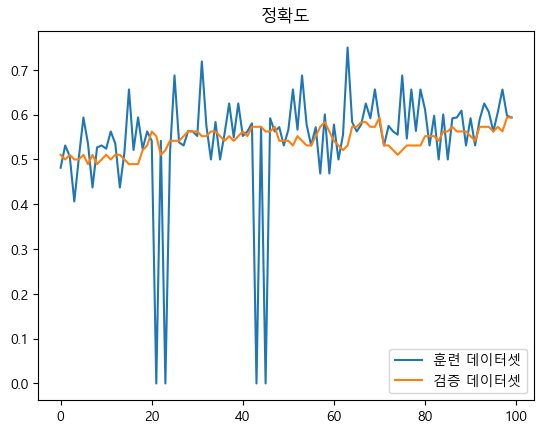

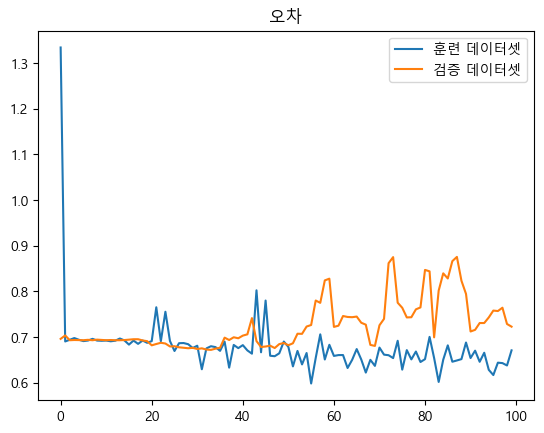

In [36]:
# 모델의 정확도 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager

# matplotlib에는 한글 인코딩 값이 없음 -> 한글 깨짐 현상
font_fname = 'C:/Windows/Fonts/malgun.ttf'      # 주피터 노트북에서 한글 깨지는 문제 해결
font_family = font_manager.FontProperties(fname=font_fname).get_name()      # 폰트 패밀리 값 알아오기
plt.rcParams["font.family"] = font_family       # plt에 폰트 설정

# 모델 정확도 그래프 그리기
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, label="훈련 데이터셋")
plt.plot(epochs, val_accuracy, label="검증 데이터셋")
plt.legend()
plt.title('정확도')
plt.figure()

plt.plot(epochs, loss, label="훈련 데이터셋")
plt.plot(epochs, val_loss, label="검증 데이터셋")
plt.legend()
plt.title('오차')
plt.show()

In [24]:
# Dropout을 적용한 모델을 생성
# 모델 생성(드롭아웃 적용)
model2 = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64),  # Bidrectional()레이어로 변경... 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
# 훈련 작업 진행
model2.compile(loss='binary_crossentropy',          
              optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history2=model.fit(train_generator, epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,  # 정수 나누기
          validation_data=valid_generator,          # 검증 이미지 데이터
          validation_steps=valid_num // BATCH_SIZE, # 
          callbacks=[tensorboard_callback],         # callbacks 으로 텐서보드 지정(*)
          verbose=1 
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9416 - loss: 0.1316 - val_accuracy: 0.6771 - val_loss: 1.0489
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.1212 - val_accuracy: 0.6771 - val_loss: 1.0685


d:\kim\TensorFlow\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9684 - loss: 0.1019 - val_accuracy: 0.6771 - val_loss: 1.3091
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 0.6771 - val_loss: 1.3701
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9669 - loss: 0.0908 - val_accuracy: 0.6979 - val_loss: 1.1388
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9688 - loss: 0.0844 - val_accuracy: 0.7292 - val_loss: 1.0891
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9554 - loss: 0.1273 - val_accuracy: 0.6562 - val_loss: 1.2844
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0445 - val_accuracy: 0.6562 - val_loss: 1.2904
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9812 - loss: 0.0684 - val_accuracy: 0.6979 - val_loss: 1.1195
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.2340 - val_accuracy: 0

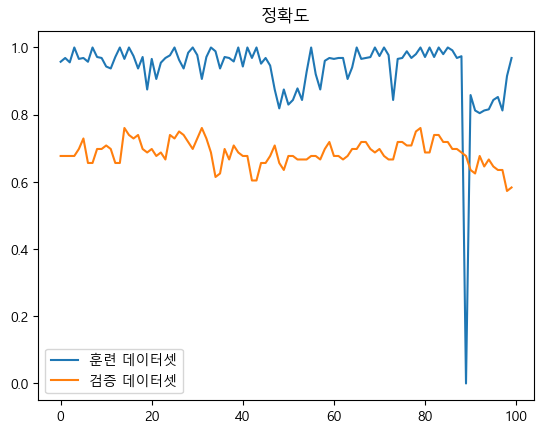

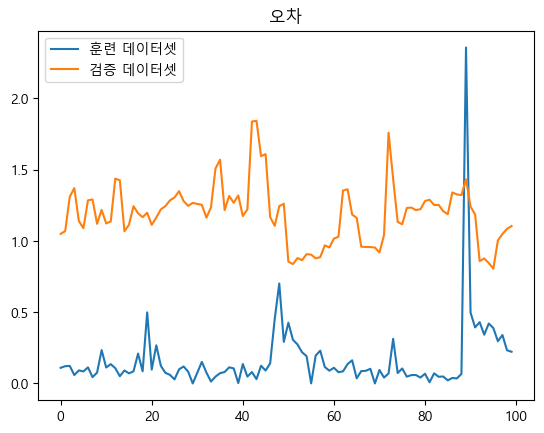

In [27]:
# 모델의 정확도 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager

# matplotlib에는 한글 인코딩 값이 없음 -> 한글 깨짐 현상
font_fname = 'C:/Windows/Fonts/malgun.ttf'      # 주피터 노트북에서 한글 깨지는 문제 해결
font_family = font_manager.FontProperties(fname=font_fname).get_name()      # 폰트 패밀리 값 알아오기
plt.rcParams["font.family"] = font_family       # plt에 폰트 설정

# 모델 정확도 그래프 그리기
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, label="훈련 데이터셋")
plt.plot(epochs, val_accuracy, label="검증 데이터셋")
plt.legend()
plt.title('정확도')
plt.figure()

plt.plot(epochs, loss, label="훈련 데이터셋")
plt.plot(epochs, val_loss, label="검증 데이터셋")
plt.legend()
plt.title('오차')
plt.show()